# Ferrofluid - Part II

## Table of Contents
1. [Applying an external magnetic field](#Applying-an-external-magnetic-field)
2. [Magnetization curve](#Magnetization-curve)

## Applying an external magnetic field

In this part we want to investigate the influence of an external magnetic field exposed to a ferrofluid system.

We import all neccessary packages

In [1]:
import espressomd

from espressomd.magnetostatics import DipolarP3M
from espressomd.magnetostatic_extensions import DLC

import numpy as np

In [1]:
print(espressomd.features())

NameError: name 'espressomd' is not defined

and set up the simulation parameters where we introduce a new dimensionless parameter 

\begin{equation}
    \alpha = \frac{\mu B}{k_BT} = \frac{\mu \mu_0 H}{k_BT}
\end{equation}

which is called Langevin parameter. We intentionally choose a relatively high volume fraction $\phi$ and dipolar interaction parameter $\lambda$ to clearly see the influence of the dipole-dipole interaction

In [3]:
# Lennard-Jones parameters
lj_sigma = 1.
lj_epsilon = 1.
lj_cut = 2**(1./6.) * lj_sigma

# Particles
N = 1000

# Area fraction of the mono-layer 
phi = 0.3

# Dipolar interaction parameter lambda = mu_0 m^2 /(4 pi sigma^3 kT)
dip_lambda = 4.

# Temperature
kT = 1.0

# Friction coefficient
gamma = 1.0

# Time step
dt = 0.01

# Langevin parameter alpha = mu_0 m H / kT
alpha = 10.

# vaccum permeability
mu_0 = 1.

# dipole moment
dipm = np.sqrt(dip_lambda*4*np.pi*lj_sigma**3.*kT / mu_0)
print('dipole moment = {}'.format(dipm))

dipole moment = 7.0898154036220635


Now we set up the system (for more details see Part I)

In [4]:
# System setup
box_size = (N * np.pi * (lj_sigma/2.)**2. /phi)**0.5

print("Box size",box_size)
# Note that the dipolar P3M and dipolar layer correction need a cubic
# simulation box for technical reasons.
system=espressomd.System(box_l=(box_size,box_size,box_size)) 
system.time_step=dt
system.thermostat.set_langevin(kT=kT,gamma=gamma)
system.set_random_state_PRNG()

# Lennard-Jones interaction
system.non_bonded_inter[0,0].lennard_jones.set_params(epsilon=lj_epsilon,sigma=lj_sigma,cutoff=lj_cut, shift="auto")

# Random dipole moments
dip_phi=np.random.random((N,1)) *2. * np.pi
dip_cos_theta = 2*np.random.random((N,1)) -1
dip_sin_theta = np.sin(np.arccos(dip_cos_theta))
dip = np.hstack((
   dip_sin_theta *np.sin(dip_phi),
   dip_sin_theta *np.cos(dip_phi),
   dip_cos_theta))

# Random positions in the monolayer
pos = box_size* np.hstack((np.random.random((N,2)), np.zeros((N,1))))

# Add particles
system.part.add(pos=pos,rotation=N*[(1,1,1)],dip=dip,fix=N*[(0,0,1)])

# Remove overlap between particles by means of the steepest descent method
system.integrator.set_steepest_descent(
    f_max=0,gamma=0.1,max_displacement=0.05)

while system.analysis.energy()["total"] > 5*kT*N:
    system.integrator.run(20)

# Switch to velocity Verlet integrator
system.integrator.set_vv()

# tune verlet list skin
system.cell_system.tune_skin(min_skin=0.4, max_skin=2., tol=0.2, int_steps=100)

# Setup dipolar P3M and dipolar layer correction
dp3m = DipolarP3M(accuracy=5E-4,prefactor=dip_lambda*lj_sigma**3*kT)
dlc = DLC(maxPWerror=1E-4, gap_size=box_size-lj_sigma)
system.actors.add(dp3m)
system.actors.add(dlc)

# tune verlet list skin again
system.cell_system.tune_skin(min_skin=0.4, max_skin=2., tol=0.2, int_steps=100)

Box size 51.166335397324424
b'Dipolar P3M tune parameters: Accuracy goal = 5.00000e-04 prefactor = 4.00000e+00\nSystem: box_l = 5.11663e+01 # charged part = 1000 Sum[q_i^2] = 1.00000e+03\nDmesh cao Dr_cut_iL   Dalpha_L     Derr         Drs_err    Dks_err    time [ms]\n8    3   2.23297e-01 8.09021e+00 4.98087e-04 3.535e-04 3.508e-04 11      \n8    2   2.36857e-01 7.30278e+00 4.93839e-04 3.535e-04 3.448e-04 12      \n8    4   2.17873e-01 8.43086e+00 4.93475e-04 3.535e-04 3.443e-04 12      \n8    1   2.72115e-01 5.58873e+00 4.98072e-04 3.535e-04 3.508e-04 13      \n10   3   2.09341e-01 9.00079e+00 4.97749e-04 3.535e-04 3.504e-04 10      \n10   2   2.23297e-01 8.09021e+00 4.99623e-04 3.535e-04 3.530e-04 11      \n10   4   2.02363e-01 9.50161e+00 4.97523e-04 3.535e-04 3.500e-04 10      \n10   5   1.98874e-01 9.76492e+00 4.94384e-04 3.536e-04 3.456e-04 14      \n12   3   1.97075e-01 9.90435e+00 4.95762e-04 3.535e-04 3.475e-04 10      \n12   2   2.09341e-01 9.00079e+00 5.26612e-04 3.535e-04 3

1.1

We now apply the external magnetic field which is

\begin{equation}
    B = \frac{\alpha~k_BT}{\mu}
\end{equation}

As only the current orientation of the dipole moments is saved in the particle list but not their strength we have to commit $B\cdot \mu$ as the external magnetic field to **ESPResSo**.
We applying the field in x-direction using the class <tt>constraints</tt> of **ESPResSo**

In [5]:
# magnetic field times dipole moment
H_dipm = (alpha*kT)
H_field = [H_dipm,0,0]
print("Set magnetic field constraint...")
H_constraint = espressomd.constraints.HomogeneousMagneticField(H=H_field)
system.constraints.add(H_constraint)

Set magnetic field constraint...


and equilibrate the system for a while

In [6]:
# Equilibrate
print("Equilibration...")
for i in range(30):
  system.integrator.run(1000)
  print("Dipolar energy: %.2f" % system.analysis.energy()["dipolar"])
  print("progress: {:6.2f} %".format((float(i)+1)/30 * 100))
print("Equilibration done")

Equilibration...
Dipolar energy: -16522.82
progress:   3.33 %
Dipolar energy: -16655.32
progress:   6.67 %
Dipolar energy: -16726.59
progress:  10.00 %
Dipolar energy: -16777.18
progress:  13.33 %
Dipolar energy: -16864.26
progress:  16.67 %
Dipolar energy: -16755.06
progress:  20.00 %
Dipolar energy: -16703.35
progress:  23.33 %
Dipolar energy: -16784.93
progress:  26.67 %
Dipolar energy: -16693.92
progress:  30.00 %
Dipolar energy: -16561.21
progress:  33.33 %
Dipolar energy: -16690.76
progress:  36.67 %
Dipolar energy: -16659.19
progress:  40.00 %
Dipolar energy: -16621.62
progress:  43.33 %
Dipolar energy: -16547.48
progress:  46.67 %
Dipolar energy: -16785.80
progress:  50.00 %
Dipolar energy: -16633.73
progress:  53.33 %
Dipolar energy: -16656.47
progress:  56.67 %
Dipolar energy: -16562.19
progress:  60.00 %
Dipolar energy: -16768.88
progress:  63.33 %
Dipolar energy: -16783.39
progress:  66.67 %
Dipolar energy: -16654.77
progress:  70.00 %
Dipolar energy: -16894.57
progress:  7

Now we can visualize the current state and see that the particles mostly create chains oriented in the direction of the external magnetic field

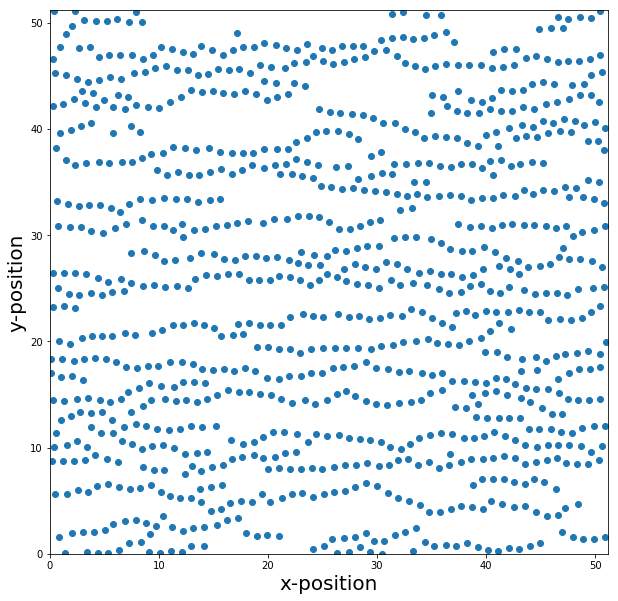

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.xlim(0, box_size)
plt.ylim(0, box_size)
plt.xlabel('x-position', fontsize=20)
plt.ylabel('y-position', fontsize=20)
plt.plot(system.part[:].pos_folded[:,0], system.part[:].pos_folded[:,1], 'o')
plt.show()

## Video of the development of the system

You may want to get an insight of how the system develops in time. Thus we now create a function which will save a video and embed it in an html string to create a video of the systems development 

In [8]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
        plt.close(anim._fig)
    return VIDEO_TAG.format(anim._encoded_video)

animation.Animation._repr_html_ = anim_to_html

def init():
    # Set x and y range
    ax.set_ylim(0, box_size)
    ax.set_xlim(0, box_size)
    xdata, ydata = [], []
    part.set_data(xdata, ydata)
    return part,

def run(i):
    system.integrator.run(50)

    # Save current system state as a plot
    xdata, ydata = system.part[:].pos_folded[:,0], system.part[:].pos_folded[:,1]
    ax.figure.canvas.draw()
    part.set_data(xdata, ydata)
    print("progress: {} %".format((float(i)+1)/100 * 100))
    return part,

We now can start the sampling over the <tt>animation</tt> class of <tt>matplotlib</tt>

progress: 1.0 %
progress: 2.0 %
progress: 3.0 %
progress: 4.0 %
progress: 5.0 %
progress: 6.0 %
progress: 7.000000000000001 %
progress: 8.0 %
progress: 9.0 %
progress: 10.0 %
progress: 11.0 %
progress: 12.0 %
progress: 13.0 %
progress: 14.000000000000002 %
progress: 15.0 %
progress: 16.0 %
progress: 17.0 %
progress: 18.0 %
progress: 19.0 %
progress: 20.0 %
progress: 21.0 %
progress: 22.0 %
progress: 23.0 %
progress: 24.0 %
progress: 25.0 %
progress: 26.0 %
progress: 27.0 %
progress: 28.000000000000004 %
progress: 28.999999999999996 %
progress: 30.0 %
progress: 31.0 %
progress: 32.0 %
progress: 33.0 %
progress: 34.0 %
progress: 35.0 %
progress: 36.0 %
progress: 37.0 %
progress: 38.0 %
progress: 39.0 %
progress: 40.0 %
progress: 41.0 %
progress: 42.0 %
progress: 43.0 %
progress: 44.0 %
progress: 45.0 %
progress: 46.0 %
progress: 47.0 %
progress: 48.0 %
progress: 49.0 %
progress: 50.0 %
progress: 51.0 %
progress: 52.0 %
progress: 53.0 %
progress: 54.0 %
progress: 55.00000000000001 %
progr

AttributeError: 'bytes' object has no attribute 'encode'

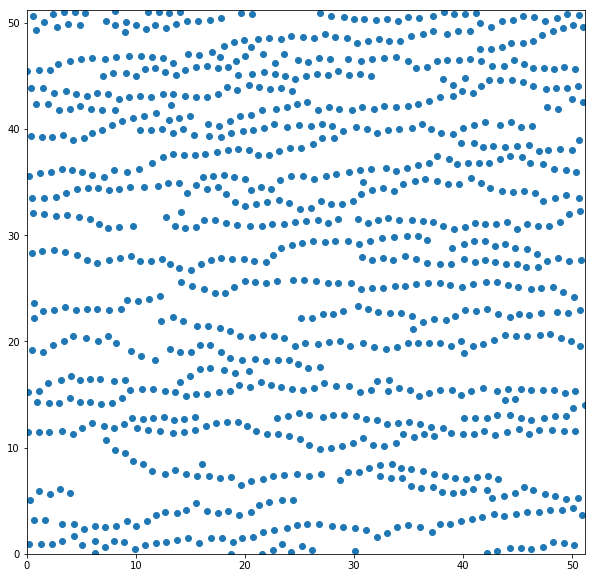

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
part, = ax.plot([],[], 'o')

animation.FuncAnimation(fig, run, frames=100, blit=True, interval=0, repeat=False, init_func=init)

In the visualization video we can see that the single chains break and connect to each other during time. Also some monomers are present which break from and connect to chains.

## Magnetization curve

An important observable of a ferrofluid system is the magnetization $M$ of the system in direction of an external magnetic field $H$

\begin{equation}
    M = \frac{\sum_i \mu_i^H}{V}
\end{equation}

where the index $H$ means the component of $\mu_i$ in direction of the external magnetic field $H$ and the sum runs over all particles.

The magnetization plotted over the external field $H$ is called magnetization curve. For particles with non-interacting dipole moments there is an analytical solution

\begin{equation}
    M = M_{sat}\cdot L(\alpha)
\end{equation}

with $L(\alpha)$ the Langevin function

\begin{equation}
    L(\alpha) = \coth(\alpha)-\frac{1}{\alpha}
\end{equation}

and $\alpha$ the Langevin parameter

\begin{equation}
    \alpha=\frac{\mu_0\mu}{k_BT}H = \frac{\mu}{k_BT}B
\end{equation}

$M_{sat}$ is the so called saturation magnetization which is the magnetization of a system where all dipole moments are aligned to each other. Thus it is the maxima of the magnetization. In our case all dipole moments are equal, thus

\begin{equation}
    M_{sat} = \frac{N\cdot\mu}{V}
\end{equation}


For better compairability we now introduce a dimensionless magnetitzation

\begin{equation}
    M^* = \frac{M}{M_{sat}} = \frac{\sum_i \mu_i^H}{N\cdot \mu}
\end{equation}

Thus the analytical solution for non-interacting dipole moments $M^*$ is simply the Langevin function.

For interacting dipole moments there are only approximations for the magnetization curve available. 

Here we want to use the approximation of Ref. [1] for a quasi two dimenstional system, which reads with adjusted coefficients (Ref. [1] used a different dipole-dipole interaction prefactor $\gamma = 1$)

\begin{equation}
    M_{||}^{q2D} = M_{sat} L(\alpha) \left( 1 + \mu_0\frac{1}{8} M_{sat} \frac{d L(\alpha)}{d\alpha} \right)
\end{equation}

and

\begin{equation}
    M_{\perp}^{q2D} = M_{sat} L(\alpha) \left( 1 - \mu_0\frac{1}{4} M_{sat} \frac{d L(\alpha)}{d\alpha} \right)
\end{equation}



for the magnetization with an external magnetic field parallel and perpendicular to the monolayer plane, respectively. Here the dipole-dipole interaction is approximated as a small perturbation.

We now want to use **ESPResSo** to get an estimation of how the magnetization curve is affected by the dipole-dipole interaction parallel and perpendicular to the monolayer plane and compare the results with the Langevin curve and the magnetization curve of Ref. [1].

For the sampling of the magnetization curve we set up a new system, where we decrease the dipolar interaction parameter $\lambda$ drastically. We do this as we want to compare our results with the approximation of Ref. [1] which is only valid for small dipole-dipole interaction between the particles (decreasing the volume fraction $\phi$ would also be an appropriate choice).

In [21]:
# Dipolar interaction parameter lambda = mu_0 m^2 /(4 pi sigma^3 kT)
dip_lambda = 0.08 

# dipole moment
dipm = np.sqrt(dip_lambda*4*np.pi*lj_sigma**3.*kT / mu_0)

In [11]:
# remove all particles
system.part[:].remove()


# Random dipole moments
dip_phi=np.random.random((N,1)) *2. * np.pi
dip_cos_theta = 2*np.random.random((N,1)) -1
dip_sin_theta = np.sin(np.arccos(dip_cos_theta))
dip = np.hstack((
   dip_sin_theta *np.sin(dip_phi),
   dip_sin_theta *np.cos(dip_phi),
   dip_cos_theta))

# Random positions in the monolayer
pos = box_size* np.hstack((np.random.random((N,2)), np.zeros((N,1))))

# Add particles
system.part.add(pos=pos,rotation=N*[(1,1,1)],dip=dip,fix=N*[(0,0,1)])

# Remove overlap between particles by means of the steepest descent method
system.integrator.set_steepest_descent(f_max=0,gamma=0.1,max_displacement=0.05)

while system.analysis.energy()["total"] > 5*kT*N:
    system.integrator.run(20)

# Switch to velocity Verlet integrator
system.integrator.set_vv()

# tune verlet list skin
system.cell_system.tune_skin(min_skin=0.4, max_skin=2., tol=0.2, int_steps=100)

# Setup dipolar P3M and dipolar layer correction
system.actors.remove(dp3m)
system.actors.remove(dlc)

dp3m = DipolarP3M(accuracy=5E-4,prefactor=dip_lambda*lj_sigma**3*kT)
dlc = DLC(maxPWerror=1E-4, gap_size=box_size-lj_sigma)

system.actors.add(dp3m)
system.actors.add(dlc)

# tune verlet list skin again
system.cell_system.tune_skin(min_skin=0.4, max_skin=2., tol=0.2, int_steps=100)

b'Dipolar P3M tune parameters: Accuracy goal = 5.00000e-04 prefactor = 8.00000e-02\nSystem: box_l = 5.11663e+01 # charged part = 1000 Sum[q_i^2] = 1.00000e+03\nDmesh cao Dr_cut_iL   Dalpha_L     Derr         Drs_err    Dks_err    time [ms]\n8    3   2.23603e-01 8.07143e+00 4.95409e-04 3.536e-04 3.470e-04 10      \n8    2   2.36981e-01 7.29601e+00 4.92882e-04 3.535e-04 3.434e-04 10      \n8    4   2.17869e-01 8.43104e+00 4.93503e-04 3.535e-04 3.443e-04 11      \n8    1   2.72337e-01 5.57916e+00 4.96696e-04 3.536e-04 3.489e-04 14      \n10   3   2.09628e-01 8.98090e+00 4.94911e-04 3.535e-04 3.463e-04 9       \n10   2   2.23603e-01 8.07143e+00 4.96956e-04 3.536e-04 3.492e-04 10      \n10   4   2.02640e-01 9.48105e+00 4.94597e-04 3.535e-04 3.459e-04 10      \n10   1   2.23603e-01 8.07143e+00 1.03811e-03 3.536e-04 9.760e-04 accuracy not achieved\n12   3   1.97345e-01 9.88325e+00 4.92836e-04 3.535e-04 3.434e-04 9       \n12   2   2.09628e-01 8.98090e+00 5.23567e-04 3.535e-04 3.862e-04 accura

0.45

To increase the perfomance we use the build-in function <tt>MagneticDipoleMoment</tt> to calculate the dipole  moment of the whole system. In our case this is only the orientation as we never commited the strength of the dipole moments to our particles. 

In [12]:
from espressomd.observables import MagneticDipoleMoment
dipm_tot = MagneticDipoleMoment(ids=system.part[:].id)

We use the dimensionless Langevin parameter $\alpha$ as the parameter for the external magnetic field. As we want the magnetization curve we create a list of them

In [13]:
alphas = np.arange(0,10).tolist()

Now we sample the magnetization for increasing $\alpha$'s or increasing magnetic field in direction perpendicular to the monolayer plane

In [14]:
# sampling with magnetic field perpendicular to monolayer plane (in z-direction)

# remove all constraints
system.constraints.clear()

# list of magnetization in field direction
magnetization_perp = []

# number of loops for sampling
loops = 100

for alpha in alphas:
    print("Sample for alpha = {}".format(alpha))
    H_dipm = (alpha*kT)
    H_field = [0,0,H_dipm]
    print("Set magnetic field constraint...")
    H_constraint = espressomd.constraints.HomogeneousMagneticField(H=H_field)
    system.constraints.add(H_constraint)
    print("done")
    
    # Equilibration
    print("Equilibration...")
    for i in range(30):
        system.integrator.run(1000)
        print("Dipolar energy: %.2f" % system.analysis.energy()["dipolar"])
        print("progress: {:6.2f} %".format((float(i)+1)/30 * 100))
    print("Equlilibration done \n")
    
    # Sampling
    print("Sampling...")
    magn_temp = 0
    for i in range(loops):
        system.integrator.run(100)
        magn_temp += dipm_tot.calculate()[2]
        print("progress: {:6.2f} %".format((float(i)+1)/loops * 100))
    
    # save average magnetization
    magnetization_perp.append(magn_temp / loops)
    print("Sampling for alpha = {} done \n".format(alpha))
    print("magnetizations = {}".format(magnetization_perp))
    print("total progress: {:6.2f} %\n".format((float(alphas.index(alpha))+1)/len(alphas) * 100))
    
    # remove constraint
    system.constraints.clear()
print("Magnetization curve sampling done")

Sample for alpha = 0
Set magnetic field constraint...
done
Equilibration...
Dipolar energy: -1.22
progress:   3.33 %
Dipolar energy: 0.88
progress:   6.67 %
Dipolar energy: -2.58
progress:  10.00 %
Dipolar energy: -2.56
progress:  13.33 %
Dipolar energy: -3.86
progress:  16.67 %
Dipolar energy: -1.24
progress:  20.00 %
Dipolar energy: -1.76
progress:  23.33 %
Dipolar energy: -0.84
progress:  26.67 %
Dipolar energy: -4.10
progress:  30.00 %
Dipolar energy: -0.92
progress:  33.33 %
Dipolar energy: -2.97
progress:  36.67 %
Dipolar energy: -1.32
progress:  40.00 %
Dipolar energy: -1.92
progress:  43.33 %
Dipolar energy: -3.41
progress:  46.67 %
Dipolar energy: -0.91
progress:  50.00 %
Dipolar energy: -3.62
progress:  53.33 %
Dipolar energy: -1.69
progress:  56.67 %
Dipolar energy: -0.00
progress:  60.00 %
Dipolar energy: -1.29
progress:  63.33 %
Dipolar energy: -2.41
progress:  66.67 %
Dipolar energy: -1.39
progress:  70.00 %
Dipolar energy: -0.96
progress:  73.33 %
Dipolar energy: -1.82
p

progress:   3.00 %
progress:   4.00 %
progress:   5.00 %
progress:   6.00 %
progress:   7.00 %
progress:   8.00 %
progress:   9.00 %
progress:  10.00 %
progress:  11.00 %
progress:  12.00 %
progress:  13.00 %
progress:  14.00 %
progress:  15.00 %
progress:  16.00 %
progress:  17.00 %
progress:  18.00 %
progress:  19.00 %
progress:  20.00 %
progress:  21.00 %
progress:  22.00 %
progress:  23.00 %
progress:  24.00 %
progress:  25.00 %
progress:  26.00 %
progress:  27.00 %
progress:  28.00 %
progress:  29.00 %
progress:  30.00 %
progress:  31.00 %
progress:  32.00 %
progress:  33.00 %
progress:  34.00 %
progress:  35.00 %
progress:  36.00 %
progress:  37.00 %
progress:  38.00 %
progress:  39.00 %
progress:  40.00 %
progress:  41.00 %
progress:  42.00 %
progress:  43.00 %
progress:  44.00 %
progress:  45.00 %
progress:  46.00 %
progress:  47.00 %
progress:  48.00 %
progress:  49.00 %
progress:  50.00 %
progress:  51.00 %
progress:  52.00 %
progress:  53.00 %
progress:  54.00 %
progress:  5

progress:  69.00 %
progress:  70.00 %
progress:  71.00 %
progress:  72.00 %
progress:  73.00 %
progress:  74.00 %
progress:  75.00 %
progress:  76.00 %
progress:  77.00 %
progress:  78.00 %
progress:  79.00 %
progress:  80.00 %
progress:  81.00 %
progress:  82.00 %
progress:  83.00 %
progress:  84.00 %
progress:  85.00 %
progress:  86.00 %
progress:  87.00 %
progress:  88.00 %
progress:  89.00 %
progress:  90.00 %
progress:  91.00 %
progress:  92.00 %
progress:  93.00 %
progress:  94.00 %
progress:  95.00 %
progress:  96.00 %
progress:  97.00 %
progress:  98.00 %
progress:  99.00 %
progress: 100.00 %
Sampling for alpha = 4 done 

magnetizations = [6.041190786912352, 293.6774810653525, 516.4915998193595, 658.3393907305958, 741.0333942528623]
total progress:  50.00 %

Sample for alpha = 5
Set magnetic field constraint...
done
Equilibration...
Dipolar energy: -3894.15
progress:   3.33 %
Dipolar energy: -3910.20
progress:   6.67 %
Dipolar energy: -3918.87
progress:  10.00 %
Dipolar energy:

Dipolar energy: -5866.92
progress:  26.67 %
Dipolar energy: -5910.68
progress:  30.00 %
Dipolar energy: -5927.51
progress:  33.33 %
Dipolar energy: -5854.62
progress:  36.67 %
Dipolar energy: -5901.96
progress:  40.00 %
Dipolar energy: -5876.78
progress:  43.33 %
Dipolar energy: -5932.88
progress:  46.67 %
Dipolar energy: -5918.05
progress:  50.00 %
Dipolar energy: -5862.42
progress:  53.33 %
Dipolar energy: -5900.59
progress:  56.67 %
Dipolar energy: -5926.60
progress:  60.00 %
Dipolar energy: -5922.46
progress:  63.33 %
Dipolar energy: -5829.21
progress:  66.67 %
Dipolar energy: -5911.88
progress:  70.00 %
Dipolar energy: -5924.12
progress:  73.33 %
Dipolar energy: -5919.59
progress:  76.67 %
Dipolar energy: -5866.07
progress:  80.00 %
Dipolar energy: -5899.31
progress:  83.33 %
Dipolar energy: -5891.34
progress:  86.67 %
Dipolar energy: -5928.21
progress:  90.00 %
Dipolar energy: -5915.71
progress:  93.33 %
Dipolar energy: -5898.09
progress:  96.67 %
Dipolar energy: -5852.61
progres

progress:   2.00 %
progress:   3.00 %
progress:   4.00 %
progress:   5.00 %
progress:   6.00 %
progress:   7.00 %
progress:   8.00 %
progress:   9.00 %
progress:  10.00 %
progress:  11.00 %
progress:  12.00 %
progress:  13.00 %
progress:  14.00 %
progress:  15.00 %
progress:  16.00 %
progress:  17.00 %
progress:  18.00 %
progress:  19.00 %
progress:  20.00 %
progress:  21.00 %
progress:  22.00 %
progress:  23.00 %
progress:  24.00 %
progress:  25.00 %
progress:  26.00 %
progress:  27.00 %
progress:  28.00 %
progress:  29.00 %
progress:  30.00 %
progress:  31.00 %
progress:  32.00 %
progress:  33.00 %
progress:  34.00 %
progress:  35.00 %
progress:  36.00 %
progress:  37.00 %
progress:  38.00 %
progress:  39.00 %
progress:  40.00 %
progress:  41.00 %
progress:  42.00 %
progress:  43.00 %
progress:  44.00 %
progress:  45.00 %
progress:  46.00 %
progress:  47.00 %
progress:  48.00 %
progress:  49.00 %
progress:  50.00 %
progress:  51.00 %
progress:  52.00 %
progress:  53.00 %
progress:  5

and now we sample the magnetization for increasing $\alpha$'s or increasing magnetic field in direction parallel to the monolayer plane

In [15]:
# sampling with magnetic field parallel to monolayer plane (in x-direction)

# remove all constraints
system.constraints.clear()

# list of magnetization in field direction
magnetization_para = []

# number of loops for sampling
loops = 100

for alpha in alphas:
    print("Sample for alpha = {}".format(alpha))
    H_dipm = (alpha*kT)
    H_field = [H_dipm,0,0]
    print("Set magnetic field constraint...")
    H_constraint = espressomd.constraints.HomogeneousMagneticField(H=H_field)
    system.constraints.add(H_constraint)
    print("done")
    
    # Equilibration
    print("Equilibration...")
    for i in range(30):
        system.integrator.run(1000)
        print("Dipolar energy: %.2f" % system.analysis.energy()["dipolar"])
        print("progress: {:6.2f} %".format((float(i)+1)/30 * 100))
    print("Equlilibration done \n")
    
    # Sampling
    print("Sampling...")
    magn_temp = 0
    for i in range(loops):
        system.integrator.run(100)
        magn_temp += dipm_tot.calculate()[0]
        print("progress: {:6.2f} %".format((float(i)+1)/loops * 100))
    
    # save average magnetization
    magnetization_para.append(magn_temp / loops)
    print("Sampling for alpha = {} done \n".format(alpha))
    print("magnetizations = {}".format(magnetization_para))
    print("total progress: {:6.2f} %\n".format((float(alphas.index(alpha))+1)/len(alphas) * 100))
    
    # remove constraint
    system.constraints.clear()
print("Magnetization curve sampling done")

Sample for alpha = 0
Set magnetic field constraint...
done
Equilibration...
Dipolar energy: 0.84
progress:   3.33 %
Dipolar energy: -0.83
progress:   6.67 %
Dipolar energy: -2.19
progress:  10.00 %
Dipolar energy: 0.05
progress:  13.33 %
Dipolar energy: 0.54
progress:  16.67 %
Dipolar energy: -1.49
progress:  20.00 %
Dipolar energy: -3.73
progress:  23.33 %
Dipolar energy: -1.39
progress:  26.67 %
Dipolar energy: -1.65
progress:  30.00 %
Dipolar energy: -1.28
progress:  33.33 %
Dipolar energy: -0.27
progress:  36.67 %
Dipolar energy: -3.72
progress:  40.00 %
Dipolar energy: 0.45
progress:  43.33 %
Dipolar energy: -1.92
progress:  46.67 %
Dipolar energy: -1.11
progress:  50.00 %
Dipolar energy: -3.48
progress:  53.33 %
Dipolar energy: -2.17
progress:  56.67 %
Dipolar energy: -4.01
progress:  60.00 %
Dipolar energy: -0.27
progress:  63.33 %
Dipolar energy: -2.98
progress:  66.67 %
Dipolar energy: -0.29
progress:  70.00 %
Dipolar energy: -2.69
progress:  73.33 %
Dipolar energy: -1.21
prog

progress:   2.00 %
progress:   3.00 %
progress:   4.00 %
progress:   5.00 %
progress:   6.00 %
progress:   7.00 %
progress:   8.00 %
progress:   9.00 %
progress:  10.00 %
progress:  11.00 %
progress:  12.00 %
progress:  13.00 %
progress:  14.00 %
progress:  15.00 %
progress:  16.00 %
progress:  17.00 %
progress:  18.00 %
progress:  19.00 %
progress:  20.00 %
progress:  21.00 %
progress:  22.00 %
progress:  23.00 %
progress:  24.00 %
progress:  25.00 %
progress:  26.00 %
progress:  27.00 %
progress:  28.00 %
progress:  29.00 %
progress:  30.00 %
progress:  31.00 %
progress:  32.00 %
progress:  33.00 %
progress:  34.00 %
progress:  35.00 %
progress:  36.00 %
progress:  37.00 %
progress:  38.00 %
progress:  39.00 %
progress:  40.00 %
progress:  41.00 %
progress:  42.00 %
progress:  43.00 %
progress:  44.00 %
progress:  45.00 %
progress:  46.00 %
progress:  47.00 %
progress:  48.00 %
progress:  49.00 %
progress:  50.00 %
progress:  51.00 %
progress:  52.00 %
progress:  53.00 %
progress:  5

progress:  68.00 %
progress:  69.00 %
progress:  70.00 %
progress:  71.00 %
progress:  72.00 %
progress:  73.00 %
progress:  74.00 %
progress:  75.00 %
progress:  76.00 %
progress:  77.00 %
progress:  78.00 %
progress:  79.00 %
progress:  80.00 %
progress:  81.00 %
progress:  82.00 %
progress:  83.00 %
progress:  84.00 %
progress:  85.00 %
progress:  86.00 %
progress:  87.00 %
progress:  88.00 %
progress:  89.00 %
progress:  90.00 %
progress:  91.00 %
progress:  92.00 %
progress:  93.00 %
progress:  94.00 %
progress:  95.00 %
progress:  96.00 %
progress:  97.00 %
progress:  98.00 %
progress:  99.00 %
progress: 100.00 %
Sampling for alpha = 4 done 

magnetizations = [-0.7927911693497894, 321.9605507644867, 545.450366787702, 680.0400772779973, 754.7687604880895]
total progress:  50.00 %

Sample for alpha = 5
Set magnetic field constraint...
done
Equilibration...
Dipolar energy: -4053.94
progress:   3.33 %
Dipolar energy: -4084.59
progress:   6.67 %
Dipolar energy: -4050.49
progress:  10.

Dipolar energy: -6045.72
progress:  23.33 %
Dipolar energy: -6031.12
progress:  26.67 %
Dipolar energy: -6051.57
progress:  30.00 %
Dipolar energy: -6090.56
progress:  33.33 %
Dipolar energy: -5984.35
progress:  36.67 %
Dipolar energy: -6063.30
progress:  40.00 %
Dipolar energy: -6065.28
progress:  43.33 %
Dipolar energy: -6037.00
progress:  46.67 %
Dipolar energy: -6076.62
progress:  50.00 %
Dipolar energy: -6028.90
progress:  53.33 %
Dipolar energy: -6063.63
progress:  56.67 %
Dipolar energy: -6062.08
progress:  60.00 %
Dipolar energy: -6056.27
progress:  63.33 %
Dipolar energy: -5936.61
progress:  66.67 %
Dipolar energy: -6016.54
progress:  70.00 %
Dipolar energy: -6045.59
progress:  73.33 %
Dipolar energy: -6027.70
progress:  76.67 %
Dipolar energy: -6034.38
progress:  80.00 %
Dipolar energy: -6072.48
progress:  83.33 %
Dipolar energy: -6067.97
progress:  86.67 %
Dipolar energy: -6043.09
progress:  90.00 %
Dipolar energy: -6058.60
progress:  93.33 %
Dipolar energy: -6074.13
progres

progress:   1.00 %
progress:   2.00 %
progress:   3.00 %
progress:   4.00 %
progress:   5.00 %
progress:   6.00 %
progress:   7.00 %
progress:   8.00 %
progress:   9.00 %
progress:  10.00 %
progress:  11.00 %
progress:  12.00 %
progress:  13.00 %
progress:  14.00 %
progress:  15.00 %
progress:  16.00 %
progress:  17.00 %
progress:  18.00 %
progress:  19.00 %
progress:  20.00 %
progress:  21.00 %
progress:  22.00 %
progress:  23.00 %
progress:  24.00 %
progress:  25.00 %
progress:  26.00 %
progress:  27.00 %
progress:  28.00 %
progress:  29.00 %
progress:  30.00 %
progress:  31.00 %
progress:  32.00 %
progress:  33.00 %
progress:  34.00 %
progress:  35.00 %
progress:  36.00 %
progress:  37.00 %
progress:  38.00 %
progress:  39.00 %
progress:  40.00 %
progress:  41.00 %
progress:  42.00 %
progress:  43.00 %
progress:  44.00 %
progress:  45.00 %
progress:  46.00 %
progress:  47.00 %
progress:  48.00 %
progress:  49.00 %
progress:  50.00 %
progress:  51.00 %
progress:  52.00 %
progress:  5

Now we can compare the resulting magnetization curves with the Langevin curve and the more advanced one of Ref. [1] by plotting all of them in one figure

In [16]:
import matplotlib.pyplot as plt

In [17]:
# approximated magnetization curve for a field parallel to the monolayer plane
def magnetization_approx_para(phi, dipm, alpha):
    return L(alpha) * ( 1. + mu_0/8. * 4./(np.pi*lj_sigma**2.)*phi*dipm * ( 1./(alpha**2.) - 1./((np.sinh(alpha))**2.) ) )

In [18]:
# approximated magnetization curve for a field perpendicular to the monolayer plane
def magnetization_approx_perp(phi, dipm, alpha):
    return L(alpha) * ( 1. - mu_0/4. * 4./(np.pi*lj_sigma**2.)*phi*dipm * ( 1./(alpha**2.) - 1./((np.sinh(alpha))**2.) ) )

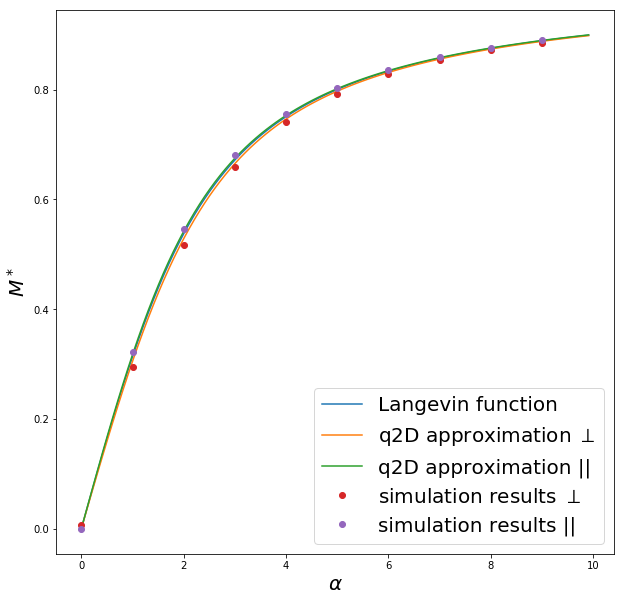

In [23]:
# Langevin function
def L(y):
    return (np.cosh(y)/np.sinh(y)) - 1./y

y = np.arange(0.01,10, 0.1, dtype=float).tolist()


L_func = []
L_iv = []
L_perp = []
L_para = []
for i in y:
    L_func.append(L(i))
    L_perp.append(magnetization_approx_perp(phi, dipm, i))
    L_para.append(magnetization_approx_para(phi, dipm, i))
    

# devide all entries in the magnetization list by N to get the dimensionless magnetization

magnetization_perp_star = []
magnetization_para_star = []
for i in range(len(magnetization_para)):
    magnetization_perp_star.append(magnetization_perp[i] / N)
    magnetization_para_star.append(magnetization_para[i] / N)

plt.figure(figsize=(10,10))
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel(r'$M^*$', fontsize=20)
plt.plot(y, L_func, label='Langevin function')
plt.plot(y, L_perp, label='q2D approximation $\perp$')
plt.plot(y, L_para, label='q2D approximation ||')
plt.plot(alphas, magnetization_perp_star, 'o', label='simulation results $\perp$')
plt.plot(alphas, magnetization_para_star, 'o', label='simulation results ||')
plt.legend(fontsize=20)
plt.show()

We can see that the simulation results are better represented by the curves of Ref. [1] compared to the Langevin function. This was to be expected as the Langevin function is the magnetization curve of the real three dimenstional system without dipole-dipole interaction.

Feel free to experiment with different dipolar interaction parameters $\lambda$ up to around 4 and different area fractions $\phi$ up to around 0.4. For higher values the here used simple sampling method is not applicable as the particles form clusters of very high relaxation times exceeding normal simulation times by far. Therefore more advanced methods are necessary to increase the sampling performance.

[1] Tamás Kristóf and István Szalai. “Magnetic properties in monolayers of a model
polydisperse ferrofluid”. In: Phys. Rev. E 72 (4 Oct. 2005), p. 041105. doi: 10.1103/
PhysRevE.72.041105. url: https://link.aps.org/doi/10.1103/PhysRevE.72.
041105.